In [1]:
from utils import *
from bs4 import BeautifulSoup
from PIL import Image, ImageDraw
from IPython.display import display
from matplotlib import pyplot as plt
import os

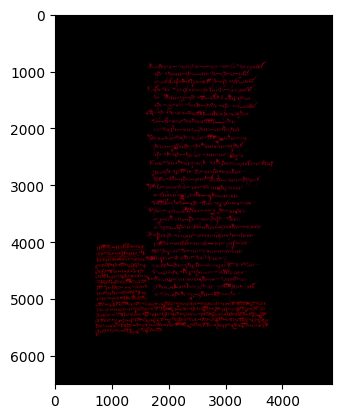

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = 'all/pixel-level-gt-CB55/pixel-level-gt/training/e-codices_fmb-cb-0055_0008v_max.png'

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.show()

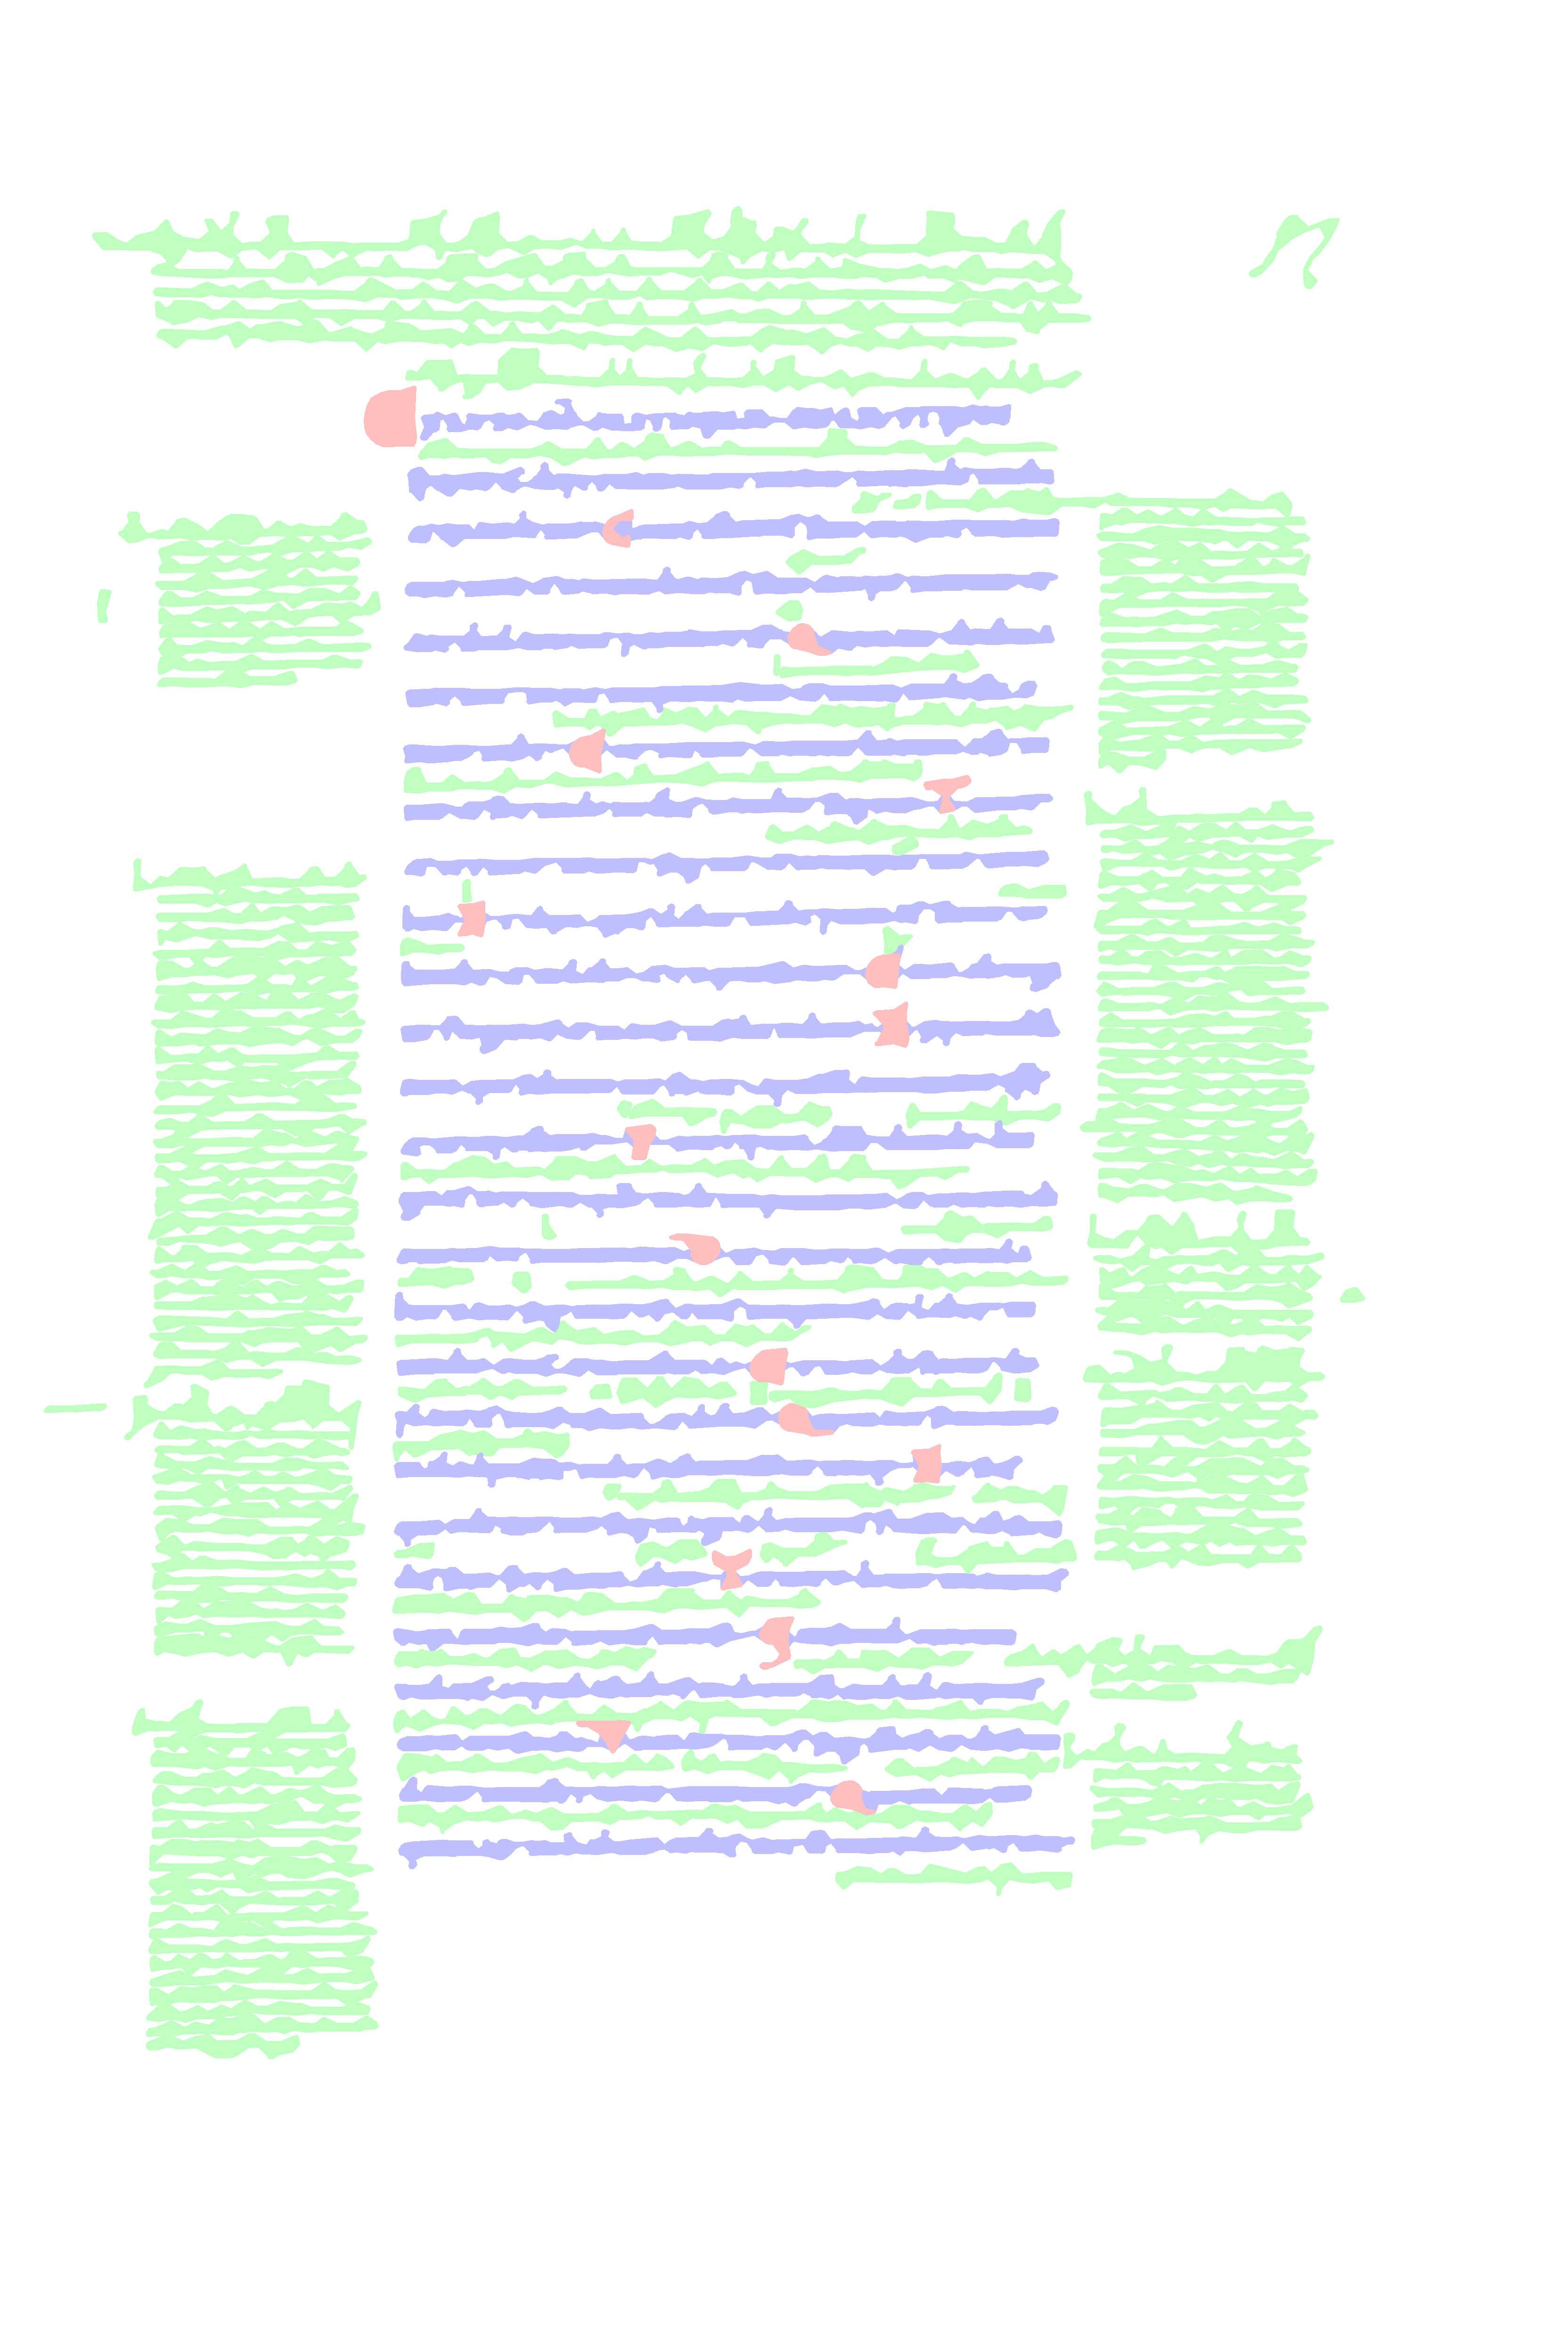

In [3]:
# Read the XML file
with open('all/PAGE-gt-CS18/PAGE-gt/training/e-codices_csg-0018_097_max.xml', 'r') as file:
    xml_data = file.read()

# Parse the XML using BeautifulSoup with 'lxml-xml' parser
soup = BeautifulSoup(xml_data, 'lxml-xml')

# Find all TextLine elements with an id containing 'comment'
textlines_with_comment = soup.find_all('GraphicRegion', {'id': lambda x: x and 'region' in x})

# Extract Coords points for each matching TextLine
coordinates_by_group = {"comment":[],"body":[],"decoration":[]}
search = {"comment":["TextLine","comment"],"body":["TextLine","textline"],"decoration":["GraphicRegion","region"]}
for group in coordinates_by_group.keys():
    textlines_with_comment = soup.find_all(search[group][0], {'id': lambda x: x and search[group][1] in x})
    for textline in textlines_with_comment:
        coords_points = textline.find('Coords')['points']
        coordinate_pairs = coords_points.split()
        coordinates_list = [tuple(map(int, pair.split(','))) for pair in coordinate_pairs]
        coordinates_by_group[group].append(coordinates_list)


image_path = 'all/img-CS18/img/training/e-codices_csg-0018_097_max.jpg'
img = Image.open(image_path)

colors = {"comment":(0, 255, 0, 64),"body":(0, 0, 255, 64),"decoration":(255,0, 0, 64)}
filled_polygon_img = Image.new('RGBA', img.size, (0, 0, 0, 0))
draw_filled_polygon = ImageDraw.Draw(filled_polygon_img)

for group in coordinates_by_group.keys():
    for coords in coordinates_by_group[group]:
        polygon_coordinates = coords

        draw_filled_polygon.polygon(polygon_coordinates,outline=None,fill=colors[group])

result_img = Image.alpha_composite(img.convert('RGBA'), filled_polygon_img)
display(filled_polygon_img)

In [2]:
def parse_images_from_folder(image_path, xml_path):
    xml_files = os.listdir(xml_path)
    image_files = os.listdir(image_path)
    output = []
    for i in range(len(xml_files)):
        img_file_path = image_path + "/" + image_files[i]
        xml_file_path = xml_path + "/" + xml_files[i]
        page = Page.from_file(img_file_path,xml_file_path)
        output.append(page)
    return output

haha = parse_images_from_folder("all/img-CS18/img/training","all/PAGE-gt-CS18/PAGE-gt/training")

In [5]:
haha[0].img.shape

(4992, 3328, 3)

möjliga square patches: 

* 832: 6*4 samples per bild
* 416: 12*8 samples per bild

In [5]:
patches = haha[0].divide_image_into_square_patches(832)
haha[0].grid

[(x=0, y=0),
 (x=0, y=1),
 (x=0, y=2),
 (x=0, y=3),
 (x=1, y=0),
 (x=1, y=1),
 (x=1, y=2),
 (x=1, y=3),
 (x=2, y=0),
 (x=2, y=1),
 (x=2, y=2),
 (x=2, y=3),
 (x=3, y=0),
 (x=3, y=1),
 (x=3, y=2),
 (x=3, y=3),
 (x=4, y=0),
 (x=4, y=1),
 (x=4, y=2),
 (x=4, y=3),
 (x=5, y=0),
 (x=5, y=1),
 (x=5, y=2),
 (x=5, y=3)]

In [11]:
pic = Image.fromarray(haha[7].grid[0].img)
display(pic)

IndexError: list index out of range

: 

In [8]:
patches[0,:,:,:].transpo.max()

21

In [66]:
def draw_grid_on_image(image, grid_x, grid_y, line_color=(0, 0, 255), line_width=4):
    """
    Draws a grid on an image and saves the result.

    Parameters:
    - image_path: Path to the original image.
    - grid_x, grid_y: The number of divisions along the x and y axes.
    - line_color: Color of the grid lines as an RGB tuple. Default is red.
    - line_width: The width of the grid lines. Default is 1.
    """
    with Image.fromarray(image) as img:
        draw = ImageDraw.Draw(img)
        width, height = img.size

        # Calculate the distance between each line
        step_x = width / grid_x
        step_y = height / grid_y

        # Draw vertical lines
        for x in range(1, grid_x):
            start = x * step_x
            draw.line((start, 0, start, height), fill=line_color, width=line_width)

        # Draw horizontal lines
        for y in range(1, grid_y):
            start = y * step_y
            draw.line((0, start, width, start), fill=line_color, width=line_width)
        #REMOVE WHEN CREATING SAMPLE PICTURES FOR REPORT
        img  = img.resize((int(img.width/4),int(img.height/4)))
        # Display the result
        display(img)

# Example usage
# draw_grid_on_image('path/to/your/image.jpg', grid_x=4, grid_y=4)

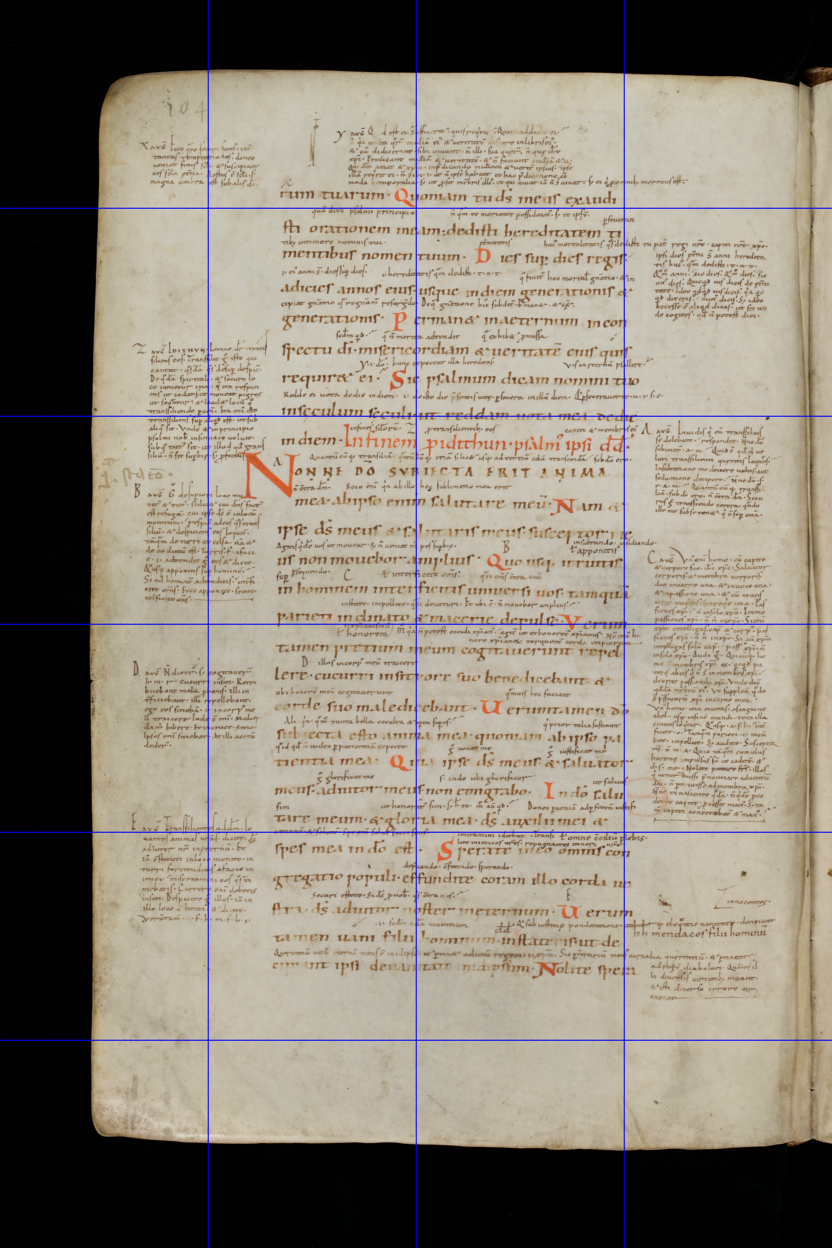

In [69]:
draw_grid_on_image(haha[5].img,4,6)



['<id>','uri','ns6__usecaseId', 'ns6__prequisiteConstrainAssumptions','ns6__usecaseText','ns6__title','ns6__scenarios','ns6__description','ns6__requirements','ns6__actors','ns2__ModifyTime','ns2__locationURL','ns2__title','ns2__downloadURL']

In [14]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

6

In [3]:
import torch


In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
model.train(True)

Using cache found in C:\Users\dator/.cache\torch\hub\pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se